In [1]:
import ROOT as rt
import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/nfshome/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list
import math
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.16/00
3.6.8 (default, Apr 25 2019, 21:02:35) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-36)]


In [6]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
bkg_path = "/mnt/hadoop/store/group/phys_exotica/delayedjets/jet_timing_studies/christiw/RunIIFall17DRPremix_QCD_upperbound/"
sig_path = "/mnt/hadoop/store/group/phys_exotica/delayedjets/jet_timing_studies/christiw/signal/bbbb/vh/"

# bkg_path = "/nfshome/christiw/llp/jet_timing_studies_root/gammaMax_p/"

lumi = 137000 #in pb-1

# fpath_bkg['QCD15'] = bkg_path+"ntuple_RunIIFall17_QCD_Pt_15to30_TuneCP5_13TeV_pythia8.root"
fpath_bkg['QCD30'] = bkg_path+"ntuple_RunIIFall17_QCD_Pt_30to50_TuneCP5_13TeV_pythia8.root"
# fpath_bkg['QCD170'] = bkg_path+"jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8.root"
fpath_bkg['bbbb_mh125_ctau1'] = sig_path+'ntuple_RunIISummer16_bbbb_vh_mh125_mx50_pl1000.root'
# fpath_bkg['bbbb_mh2000_ctau1'] = sig_path+'ntuple_RunIISummer16_bbbb_vh_mh2000_mx975_pl1000.root'
# fpath_bkg['bbbb_mh125_ctau10'] = sig_path+'ntuple_RunIISummer16_bbbb_vh_mh125_mx50_pl10000.root'
# fpath_bkg['bbbb_mh2000_ctau10'] = sig_path+'ntuple_RunIISummer16_bbbb_vh_mh2000_mx975_pl10000.root'

# process['glueBall'] = 'pp #rightarrow  #rightarrow bbbb'

start_t = time.time()

for k,v in fpath_bkg.items():
    print (k, v)

    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['ntuples']['llp']
    a = tree_bkg[k]["jetPt"].array()
    a = tree_bkg[k].get("jetPt")
    print (len(a))
print("time: "+str(time.time()-start_t))

QCD30 /mnt/hadoop/store/group/phys_exotica/delayedjets/jet_timing_studies/christiw/RunIIFall17DRPremix_QCD_upperbound/ntuple_RunIIFall17_QCD_Pt_30to50_TuneCP5_13TeV_pythia8.root
63826
bbbb_mh125_ctau1 /mnt/hadoop/store/group/phys_exotica/delayedjets/jet_timing_studies/christiw/signal/bbbb/vh/ntuple_RunIISummer16_bbbb_vh_mh125_mx50_pl1000.root
74588
time: 1.3878998756408691


In [7]:
legend = {}
legend['bbbb_mh125_ctau1'] = 'Signal (m_{h} ,m_{x})=(125, 50) GeV, c#tau = 1 m'
legend['bbbb_mh2000_ctau1'] = 'Signal (m_{h} ,m_{x})=(2000, 975) GeV, c#tau = 1 m'
legend['bbbb_mh125_ctau10'] = 'Signal (m_{h} ,m_{x})=(125, 50) GeV, c#tau = 10 m'
legend['bbbb_mh2000_ctau10'] = 'Signal (m_{h} ,m_{x})=(2000, 975) GeV, c#tau = 10 m'
legend['QCD15'] = 'QCD Pt 15-30 GeV'
legend['QCD30'] = 'QCD Pt 30-50 GeV'



wH = 1


trigger_names_file = '/nfshome/christiw/llp/delayed_jet_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
if wH:
    trigger_paths = [87,135] #PFMET120
else:
    trigger_paths = [177,362,87,135] #PFMET120

# 177 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
# 362 HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ
# 310 HLT_PFMET120_PFMHT120_IDTight
# 87 HLT_Ele32_WPTight_Gsf
# 135 HLT_IsoMu24
# 310 PFMET


In [11]:
def deltaPhi( phi1,  phi2):

    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
  
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5
def ptD(pt_list):
    pt_list = np.array(pt_list)
    return np.sum(pt_list*pt_list)**0.5/np.sum(pt_list)
def moment_diag(pt,pos):#list of pt, pos is list of eta or phi
    mean_pos = np.sum(pt*pt*pos)/np.sum(pt*pt)
    return np.sum(pt*pt*(pos-mean_pos)*(pos-mean_pos))
def moment_xterm(pt,eta,phi):#list of pt, pos is list of eta or phi
    mean_eta = np.sum(pt*pt*eta)/np.sum(pt*pt)
    mean_phi = np.sum(pt*pt*phi)/np.sum(pt*pt)
    return -np.sum(pt*pt*(phi-mean_phi)*(eta-mean_eta))
def sig(pt,eta,phi):
    pt = np.array(pt)
    eta = np.array(eta)
    phi = np.array(phi)
    m11 = moment_diag(pt,eta)
    m22 = moment_diag(pt,phi)
    m12 = moment_xterm(pt,eta,phi)
    a = (m11+m22)/2
    b = 0.5*((m11+m22)**2-4*(m11*m22-m12**2))**0.5
    #returns sig1,sig2
    return ((a+b)/np.sum(pt*pt))**0.5, ((a-b)/np.sum(pt*pt))**0.5


In [37]:
met_cut = 30 #GeV
jetTime_cut = 1 #ns
lepid = 13 #muon
dr = 0.2

jetPt = {}
jetEta = {}
jetPhi = {}
jetTime = {}
jetTime_max = {}
jet_frac_energy = {}
jetTime_median = {}
jetTime_deltaRp15 = {}
jetTime_max_deltaRp15 = {}
jetEcalEnergy = {}
eventNum = {}
genTime = {}
gLLP_decay_radius  = {}
jet_rechits_T = {}
jet_rechits_E = {}
jet_rechits_eta = {}
jet_rechits_phi = {}
rechit_deltaR = {}


etD = {}
eD = {}
sig_e1 = {}
sig_e2 = {}
sig_et1 = {}
sig_et2 = {}
sig_e = {}
sig_et = {}
start_t = time.time()

for k in tree_bkg.keys():
    if True:
        genTime[k] = []
        gLLP_decay_radius[k] = []
        jetPt[k] = []
        jetEta[k] = []
        jetPhi[k] = []
        jetTime[k] = []
        jetTime_max[k] = []
        jet_frac_energy[k] = []
        jetTime_deltaRp15[k] = []
        jetTime_max_deltaRp15[k] = []
        jetEcalEnergy[k] = []
        rechit_deltaR[k] = []
        jet_rechits_T[k] = []
        jet_rechits_E[k] = []
        jet_rechits_eta[k] = []
        jet_rechits_phi[k] = []
        jetTime_median[k] = []


        etD[k] = []
        eD[k] = []
        sig_e1[k] = []
        sig_e2[k] = []
        sig_et1[k] = []
        sig_et2[k] = []
        sig_e[k] = []
        sig_et[k] = []
        
        T = tree_bkg[k]
        eventNum[k] = T.array('eventNum')

        jet_n_rechits_temp =T.array('jet_n_rechits_Ecut0p5')
        jetEta_temp =T.array('jetEta')
        jetPhi_temp = T.array('jetPhi')
        jetPt_temp = T.array('jetPt')
        jetEcalEnergy_temp =T.array('jet_rechit_E_Ecut0p5')
        jetTime_temp =T.array('jet_rechit_T_Ecut0p5')

        jet_rechits_T_temp = T.array('jet_rechits_T')
        jet_rechits_E_temp = T.array('jet_rechits_E')
        jet_rechits_eta_temp = T.array('jet_rechits_eta')
        jet_rechits_phi_temp = T.array('jet_rechits_phi')
        
        genTime_temp = T.array('gen_time')
        gLLP_decay_radius_temp =  ((T.array('gLLP_decay_vertex_x')-T.array('gLLP_prod_vertex_x'))**2+(T.array('gLLP_decay_vertex_y')-T.array('gLLP_prod_vertex_y'))**2)**0.5
        gLLP_daughter_match_jet_index = T.array('gLLP_daughter_match_jet_index')
        nJets = T.array('nJets')
        for ev in range(len(nJets)):
            for j in range(nJets[ev]):
                if jet_n_rechits_temp[ev][j]<5:continue
                if abs(jetEta_temp[ev][j]) > 1.48: continue
                if not k[:3]=='QCD' and j not in  gLLP_daughter_match_jet_index[ev]: continue
                    
                if not k[:3] == 'QCD':
                    genTime[k].append(genTime_temp[ev][list(gLLP_daughter_match_jet_index[ev]).index(j)])
                    llp_id = 666
                    if list(gLLP_daughter_match_jet_index[ev]).index(j)<=1:
                        llp_id = 0
                    else:
                        llp_id = 1
                    gLLP_decay_radius[k].append(gLLP_decay_radius_temp[ev][llp_id])

                jetTime[k].append(jetTime_temp[ev][j])
                jetEcalEnergy[k].append(jetEcalEnergy_temp[ev][j])
                maxE_rechit_index = jet_rechits_E_temp[ev][j].index(max(jet_rechits_E_temp[ev][j]))
                jetTime_max[k].append(jet_rechits_T_temp[ev][j][maxE_rechit_index])
                jetTime_median[k].append(np.median(np.array(jet_rechits_T_temp[ev][j])))
                jet_rechits_T[k].append(jet_rechits_T_temp[ev][j])
                jet_rechits_E[k].append(jet_rechits_E_temp[ev][j])
                jet_rechits_eta[k].append(jet_rechits_eta_temp[ev][j])
                jet_rechits_phi[k].append(jet_rechits_phi_temp[ev][j])
                
                sig1,sig2 = sig(jet_rechits_E_temp[ev][j],jet_rechits_eta_temp[ev][j],jet_rechits_phi_temp[ev][j])
                sig_e1[k].append(sig1)
                sig_e2[k].append(sig2)
                rechits_et = jet_rechits_E_temp[ev][j]/np.cosh(jet_rechits_eta_temp[ev][j])
                sig1,sig2 = sig(rechits_et,jet_rechits_eta_temp[ev][j],jet_rechits_phi_temp[ev][j])
                sig_et1[k].append(sig1)
                sig_et2[k].append(sig2)
                etD[k].append(ptD(rechits_et))
                eD[k].append(ptD(jet_rechits_E_temp[ev][j]))




                
                ## Match rechits within deltaR = 1.5 of pf jet
                energy_deltaRp15 = 0.0
                time_deltaRp15 = 0.0
                jetTime_maxE_deltaRp15_temp = 0
                jetE_maxE_deltaRp15_temp = 0
                deltaR_temp = []
                for rec_i, rechit_t in enumerate(jet_rechits_T_temp[ev][j]):
                    if abs(jet_rechits_T_temp[ev][j][rec_i]) > 12.5: continue
                    if jet_rechits_E_temp[ev][j][rec_i] < 0.5: continue
                    deltar = deltaR(jetEta_temp[ev][j],jetPhi_temp[ev][j],jet_rechits_eta_temp[ev][j][rec_i],jet_rechits_phi_temp[ev][j][rec_i])
                    deltaR_temp.append(deltar)
                    if deltar < dr:
                        energy_deltaRp15 += jet_rechits_E_temp[ev][j][rec_i]
                        time_deltaRp15 += jet_rechits_T_temp[ev][j][rec_i] * jet_rechits_E_temp[ev][j][rec_i]
                        if jet_rechits_E_temp[ev][j][rec_i] > jetE_maxE_deltaRp15_temp:
                            jetTime_maxE_deltaRp15_temp = jet_rechits_T_temp[ev][j][rec_i]
                            jetE_maxE_deltaRp15_temp = jet_rechits_E_temp[ev][j][rec_i]
                jet_frac_energy[k].append(energy_deltaRp15/jetEcalEnergy_temp[ev][j])
                jetTime_max_deltaRp15[k].append(jetTime_maxE_deltaRp15_temp)
                
                if not energy_deltaRp15 == 0:
                    jetTime_deltaRp15[k].append(time_deltaRp15/energy_deltaRp15)
                else:
                    assert(time_deltaRp15 == energy_deltaRp15)
                    jetTime_deltaRp15[k].append(time_deltaRp15)
                
                jetPt[k].append(jetPt_temp[ev][j])
                jetEta[k].append(jetEta_temp[ev][j])
                jetPhi[k].append(jetPhi_temp[ev][j])
                rechit_deltaR[k].append(deltaR_temp)
        rechit_deltaR[k] = np.array(rechit_deltaR[k])
        genTime[k] = np.array(genTime[k])
        gLLP_decay_radius[k] = np.array(gLLP_decay_radius[k])
        jetPt[k] = np.array(jetPt[k])
        jetEta[k] = np.array(jetEta[k])
        jetPhi[k] = np.array(jetPhi[k])
        jetTime[k] = np.array(jetTime[k])
        jetTime_max[k] = np.array(jetTime_max[k])
        jet_frac_energy[k] = np.array(jet_frac_energy[k])
        jetTime_deltaRp15[k] = np.array(jetTime_deltaRp15[k])
        jetTime_max_deltaRp15[k] = np.array(jetTime_max_deltaRp15[k])
        jetTime_median[k] = np.array(jetTime_median[k])
        jet_rechits_T[k] = np.array(jet_rechits_T[k])
        jet_rechits_E[k] = np.array(jet_rechits_E[k])
        jet_rechits_eta[k] = np.array(jet_rechits_eta[k])
        jet_rechits_phi[k] = np.array(jet_rechits_phi[k])
        jetEcalEnergy[k] = np.array(jetEcalEnergy[k])
        etD[k] = np.array(etD[k])
        eD[k] = np.array(eD[k])
        sig_e1[k] = np.array(sig_e1[k])
        sig_e2[k] = np.array(sig_e2[k])
        sig_et1[k] = np.array(sig_et1[k])
        sig_et2[k] = np.array(sig_et2[k])
        sig_e[k] = np.hypot(sig_e1[k],sig_e2[k])
        sig_et[k] = np.hypot(sig_et1[k],sig_et2[k])

        
        print(k,len(nJets),len(jetPhi[k]),(time.time()-start_t))
        start_t = time.time()
    else:
        print(k)

QCD30 63826 29809 186.01276969909668
bbbb_mh125_ctau1 74588 27285 277.8021881580353


# match rechits within 0.15 cone to jets

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


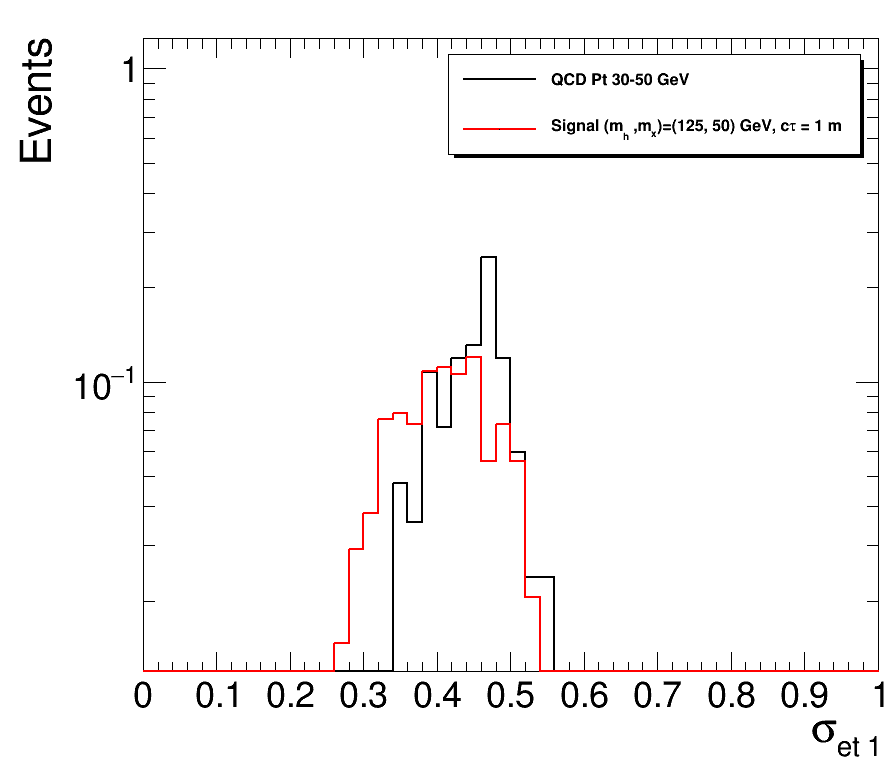

In [42]:
# gen vs. reco time for matched signals

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.50,0.80,0.96,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
i=0
for k,v in jetTime.items():
#     print(jet_frac_energy[k])
    jet_frac_energy[k] = np.array(jet_frac_energy[k])
    cond = np.ones(jet_frac_energy[k].shape,dtype=bool)
    cond = jetTime[k]>3
#     if not k[:3] == 'QCD':
#         gLLP_decay_radius[k] = np.array(gLLP_decay_radius[k])
#         cond = gLLP_decay_radius[k] > 50
#         cond = np.logical_and(cond,gLLP_decay_z[k]>20)
    
#     h[k] = create_TH1D(sig_et2[k],axis_title = ['#sigma_{et 1}','Events'], binning=[50,0,0.3])
    h[k] = create_TH1D(np.hypot(sig_e1[k][cond],sig_e2[k][cond]),axis_title = ['#sigma_{et 1}','Events'], binning=[50,0,0.3])
    h[k] = create_TH1D(etD[k][cond],axis_title = ['#sigma_{et 1}','Events'], binning=[50,0,1])




#     h[k] = create_TH1D(jet_frac_energy[k][cond],axis_title = ['Energy fraction','Events'], binning=[50,0,1])
    currentMax=h[k].GetBinContent(h[k].GetMaximumBin())
    if currentMax > max_y:
        max_y = currentMax
        h[k].SetMaximum(5*currentMax)
        h[k].SetMinimum(1)
    h[k].SetLineColor(std_color_list[i])
    leg.AddEntry(h[k], legend[k])
    h[k].DrawNormalized('same')
    i+=1
    #     c.SetRightMargin(0.17)
leg.Draw()


c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/deltar0p15vs0p4_energyfrac_matched.png')
#     c.SaveAs('../plots/timing_studies/matched_tresponse_jetpt_'+k+'.png')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


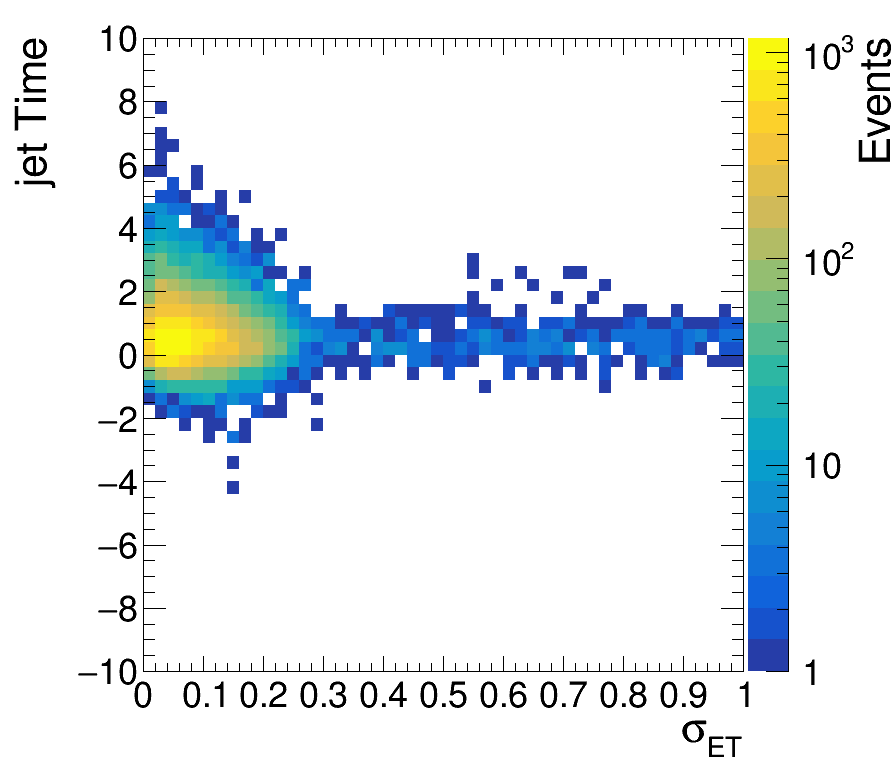

In [51]:
# gen vs. reco time for matched signals

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.40,0.75,0.95,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
i=0
key = 'bbbb_mh125_ctau1'
# h['bbbb_mh125_ctau1'] = create_TH2D(np.column_stack((gLLP_decay_radius['bbbb_mh125_ctau1'],jetTime['bbbb_mh125_ctau1'])), axis_title = ['gLLP decay radius [cm]','ECAL #Delta R = 0.15 energy fraction','Events'], binning=[50,0,140,50,-10,10])
# h['bbbb_mh125_ctau1'] = create_TH2D(np.column_stack((gLLP_decay_radius['bbbb_mh125_ctau1'],jet_frac_energy['bbbb_mh125_ctau1'])), axis_title = ['gLLP decay radius [cm]','ECAL #Delta R = 0.15 energy fraction','Events'], binning=[50,0,140,50,0,1])
# h['bbbb_mh125_ctau1'] = create_TH2D(np.column_stack((jet_frac_energy['bbbb_mh125_ctau1'],jetTime['bbbb_mh125_ctau1'])), axis_title = ['Energy Fraction','ECAL #Delta R = 0.15 energy fraction','Events'], binning=[50,0,1,50,-10,10])
# h['QCD30'] = create_TH2D(np.column_stack((jet_frac_energy['QCD30'],jetTime['QCD30'])), axis_title = ['Energy Fraction','jet Time','Events'], binning=[50,0,1,50,-10,10])
h[key] = create_TH2D(np.column_stack((sig_e[key],jetTime[key])), axis_title = ['#sigma_{ET}','jet Time','Events'], binning=[50,0,1,50,-10,10])




# h['QCD30'].Draw('colz')

h[key].Draw('colz')

c.SetRightMargin(0.17)


c.SetLogz()
c.Draw()
# c.SaveAs('../plots/timing_studies/deltar0p15vs0p4_energyfrac_llp_decay_radius_matched.png')

# c.SaveAs('../plots/timing_studies/matched_recotime.png')
#     c.SaveAs('../plots/timing_studies/matched_tresponse_jetpt_'+k+'.png')

# Compare max time vs. energy weighted time

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


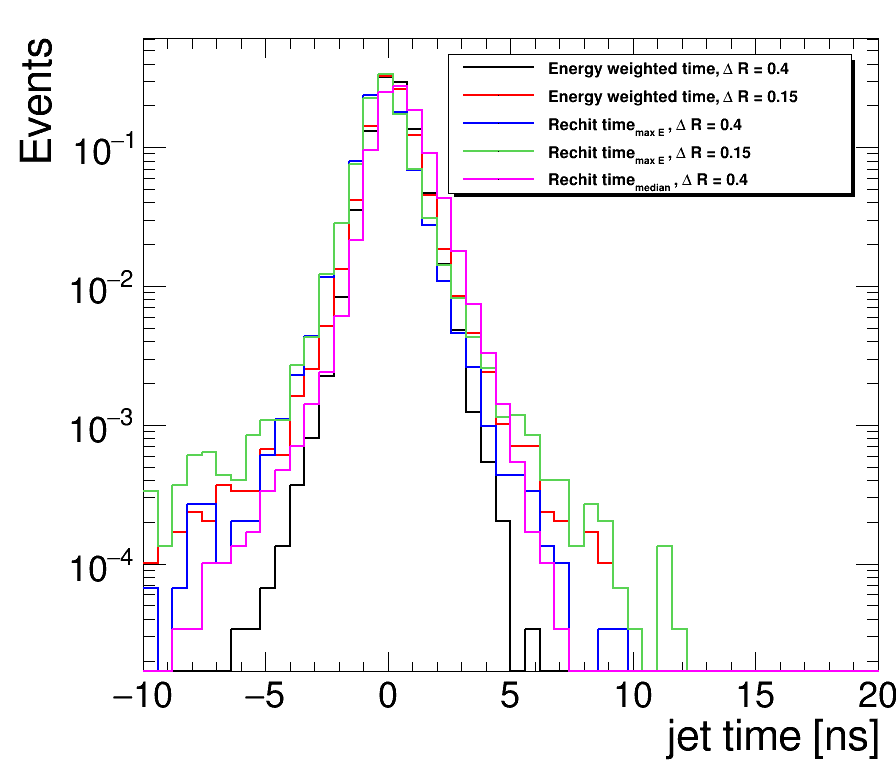

In [366]:
# gen vs. reco time for matched signals

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.50,0.75,0.95,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
i=0
k = 'QCD30'
# k = 'bbbb_mh125_ctau1'
bins = [50,-10,20]
h['jetTime'] = create_TH1D(jetTime[k],axis_title = ['jet time [ns]','Events'], binning=bins)
h['jetTime_deltaRp15'] = create_TH1D(jetTime_deltaRp15[k],axis_title = ['jet time [ns]','Events'], binning=bins)
h['jetTime_max'] = create_TH1D(jetTime_max[k],axis_title = ['jet time [ns]','Events'], binning=bins)
h['jetTime_max_deltaRp15'] = create_TH1D(jetTime_max_deltaRp15[k],axis_title = ['jet time [ns]','Events'], binning=bins)
h['jetTime_median'] = create_TH1D(jetTime_median[k],axis_title = ['jet time [ns]','Events'], binning=bins)


h['jetTime'].SetLineColor(std_color_list[0])
h['jetTime_deltaRp15'].SetLineColor(std_color_list[1])
h['jetTime_max'].SetLineColor(std_color_list[2])
h['jetTime_max_deltaRp15'].SetLineColor(std_color_list[3])
h['jetTime_median'].SetLineColor(std_color_list[4])

leg.AddEntry(h['jetTime'], 'Energy weighted time, #Delta R = 0.4')
leg.AddEntry(h['jetTime_deltaRp15'], 'Energy weighted time, #Delta R = 0.15')
leg.AddEntry(h['jetTime_max'], 'Rechit time_{max E}, #Delta R = 0.4')
leg.AddEntry(h['jetTime_max_deltaRp15'], 'Rechit time_{max E}, #Delta R = 0.15')
leg.AddEntry(h['jetTime_median'], 'Rechit time_{median}, #Delta R = 0.4')

h['jetTime'].DrawNormalized('same')
h['jetTime_deltaRp15'].DrawNormalized('same')
h['jetTime_max'].DrawNormalized('same')
h['jetTime_max_deltaRp15'].DrawNormalized('same')
h['jetTime_median'].DrawNormalized('same')

    #     c.SetRightMargin(0.17)
leg.Draw()


c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_matched_QCDpt30-50.png')
#     c.SaveAs('../plots/timing_studies/matched_tresponse_jetpt_'+k+'.png')

# bkg vs. signal for different time definition

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


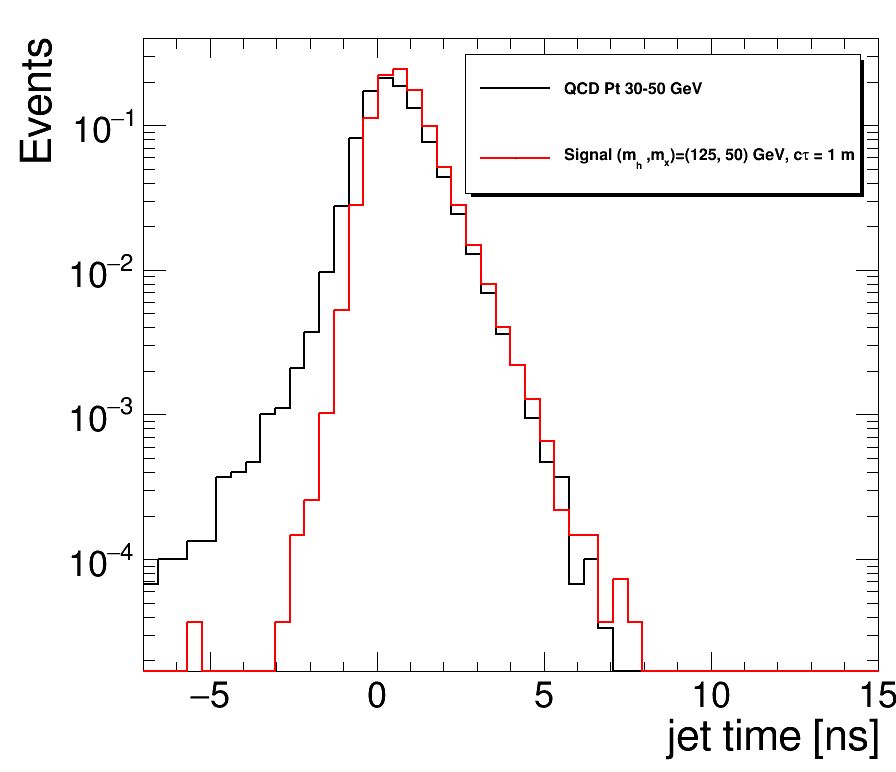

In [328]:
# gen vs. reco time for matched signals

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.52,0.75,0.96,0.93)
leg.SetTextSize(0.022)
# leg.SetBorderSize(0)

# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
i=0
time_vars = [jetTime, jetTime_median,jetTime_deltaRp15, jetTime_max, jetTime_max_deltaRp15]
time_xaxis = ['jetTime', 'jetTime_median','jetTime_deltaRp15', 'jetTime_max', 'jetTime_max_deltaRp15']
time_legend = ['Energy weighted time, #Delta R = 0.4','Rechit time_{median}, #Delta R = 0.4','Energy weighted time, #Delta R = 0.15',
              'Rechit time_{max E}, #Delta R = 0.4','Rechit time_{max E}, #Delta R = 0.15']

var_i=1
bins = [50,-7,15]
for k,v in time_vars[var_i].items():
    h[k] = create_TH1D(v,axis_title = ['jet time [ns]','Events'], binning=bins)
    h[k].SetLineColor(std_color_list[i])
    leg.AddEntry(h[k], legend[k])
    h[k].DrawNormalized('same')
    i+=1

    #     c.SetRightMargin(0.17)
leg.Draw()


c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/matched_recotime.png')
#     c.SaveAs('../plots/timing_studies/matched_tresponse_jetpt_'+k+'.png')

# ROC curve for the jet moments

(1306,) (1306,)
(1018,) (1018,)
(1304,) (1304,)
(1019,) (1019,)
(1304,) (1304,)
(1307,) (1307,)
(1068,) (1068,)
(1068,) (1068,)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ../plots/timing_studies/compare_timing_definition_ROC.png has been created


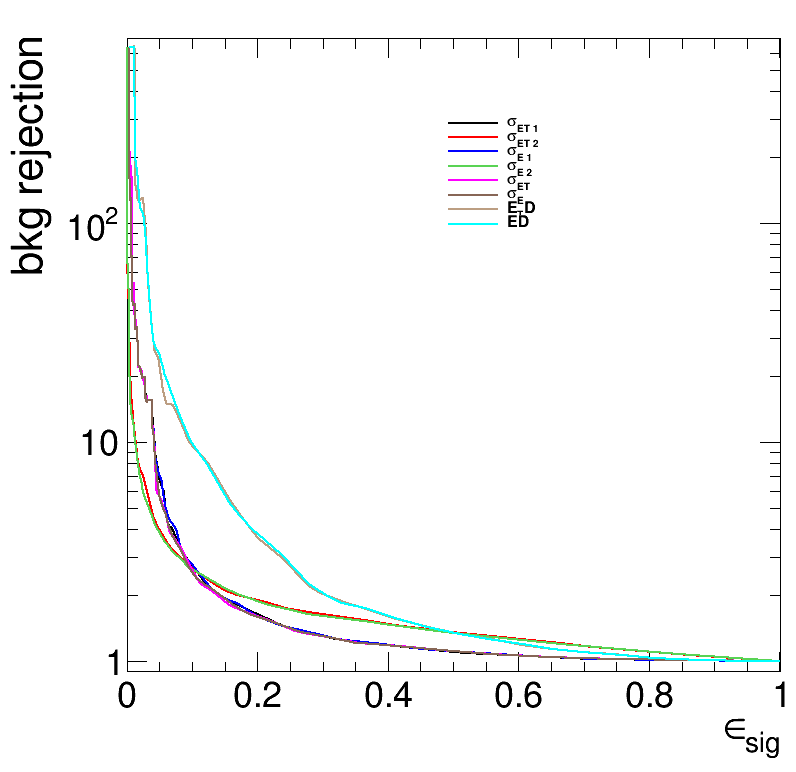

In [44]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.55,0.70,0.90,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
gr = {}
moment_vars = [sig_et1,sig_et2,sig_e1,sig_e2,sig_e,sig_et,etD,eD]
moment_xaxis = ['sig_et1','sig_et2','sig_e1','sig_e2','sig_e','sig_et','etD','eD']
moment_legend = ['#sigma_{ET 1}','#sigma_{ET 2}','#sigma_{E 1}','#sigma_{E 2}','#sigma_{ET}','#sigma_{E}','E_{T}D','ED']


qcd_key = 'QCD30'
sig_k = 'bbbb_mh125_ctau1'
for i in range(len(moment_legend)):
    eff = {}
    thre = np.array(range(1000))/1000.0
    thre = np.array(range(2500))/100.0-10
#     print(thre)
    for k in tree_bkg.keys():
        cond = jetTime[k] > 2
        v = moment_vars[i][k][cond]
        eff[k] = []
        for th in thre:
            eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
        eff[k] = np.array(eff[k])
#     Plotting ROC curve
    eff[sig_k] = eff[sig_k][np.logical_not(eff[qcd_key] == 0)]
    eff[qcd_key] = eff[qcd_key][np.logical_not(eff[qcd_key] == 0)]
    print(eff[qcd_key].shape, eff[sig_k].shape)
    gr[moment_xaxis[i]] = create_TGraph(eff[sig_k],np.reciprocal(eff[qcd_key]),axis_title = ['#epsilon_{sig}','bkg rejection'])
    gr[moment_xaxis[i]].SetLineColor(std_color_list[i])
    gr[moment_xaxis[i]].SetLineWidth(2)
    gr[moment_xaxis[i]].SetMarkerColor(std_color_list[i])

    gr[moment_xaxis[i]].SetMarkerColor(std_color_list[i])

#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
    gr[moment_xaxis[i]].GetXaxis().SetRangeUser(0.0, 1.0)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(gr[moment_xaxis[i]],moment_legend[i])

    gr[moment_xaxis[i]].Draw('ac' if i==0 else 'c')
leg.Draw()
c.SetLogy()
c.Draw()
c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')



# ROC curve for the 4 different time variables

(1592,) (1592,)
(1683,) (1683,)
(2161,) (2161,)
(1976,) (1976,)
(2161,) (2161,)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ../plots/timing_studies/compare_timing_definition_ROC.png has been created


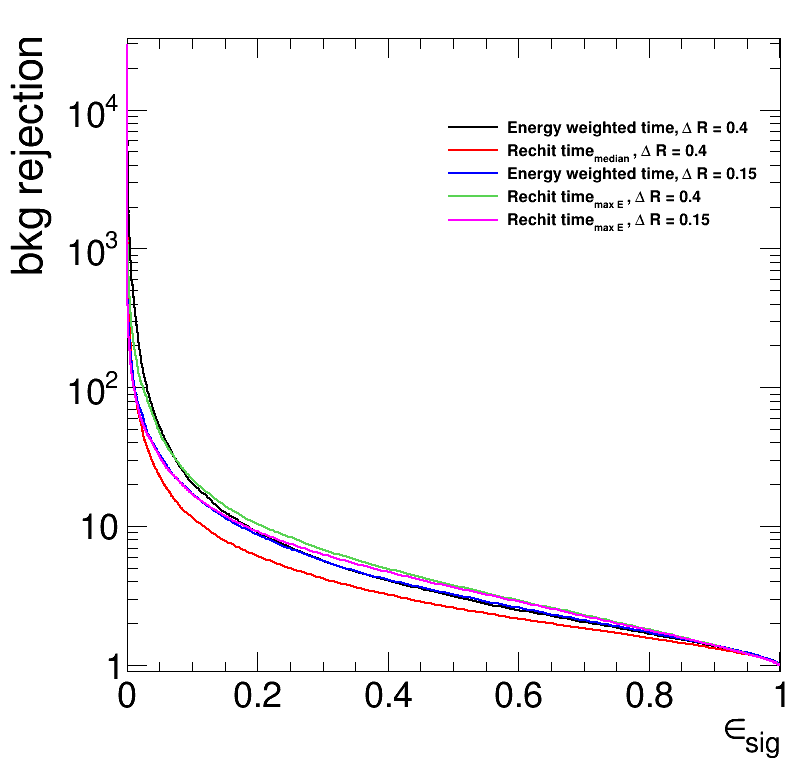

In [329]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.55,0.70,0.90,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
gr = {}
time_vars = [jetTime, jetTime_median,jetTime_deltaRp15, jetTime_max, jetTime_max_deltaRp15]
time_xaxis = ['jetTime', 'jetTime_median','jetTime_deltaRp15', 'jetTime_max', 'jetTime_max_deltaRp15']
time_legend = ['Energy weighted time, #Delta R = 0.4','Rechit time_{median}, #Delta R = 0.4','Energy weighted time, #Delta R = 0.15',
              'Rechit time_{max E}, #Delta R = 0.4','Rechit time_{max E}, #Delta R = 0.15']



# time_vars = [jet_frac_energy]
# time_xaxis = ['jet_frac_energy']

qcd_key = 'QCD30'
sig_k = 'bbbb_mh125_ctau1'
for i in range(len(time_vars)):
    v = time_vars[i]
    eff = {}
    thre = np.array(range(1000))/1000.0
    thre = np.array(range(2500))/100.0-10
#     print(thre)
    for k in tree_bkg.keys():
        v = time_vars[i][k]
        eff[k] = []
        for th in thre:
            eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
        eff[k] = np.array(eff[k])
#     Plotting ROC curve
    eff[sig_k] = eff[sig_k][np.logical_not(eff[qcd_key] == 0)]
    eff[qcd_key] = eff[qcd_key][np.logical_not(eff[qcd_key] == 0)]
    print(eff[qcd_key].shape, eff[sig_k].shape)
    gr[time_xaxis[i]] = create_TGraph(eff[sig_k],np.reciprocal(eff[qcd_key]),axis_title = ['#epsilon_{sig}','bkg rejection'])
    gr[time_xaxis[i]].SetLineColor(std_color_list[i])
    gr[time_xaxis[i]].SetLineWidth(2)
    gr[time_xaxis[i]].SetMarkerColor(std_color_list[i])

    gr[time_xaxis[i]].SetMarkerColor(std_color_list[i])

#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
    gr[time_xaxis[i]].GetXaxis().SetRangeUser(0.0, 1.0)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(gr[time_xaxis[i]],time_legend[i])

    gr[time_xaxis[i]].Draw('ac' if i==0 else 'c')
leg.Draw()
c.SetLogy()
c.Draw()
c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')


# Check events for rechit time/ energy distribution

27285
jetTime 1.0185918
jetEnergy 29.055387
nRechits 12
jet_frac_energy 0.9495813075204332
0.0
[3.0155715942382812, -0.8260368704795837, -0.7531569004058838, 1.6162186861038208, 4.326637268066406, 1.0614125728607178, 1.6273409128189087, 0.34960806369781494, 1.7754429578781128, 0.7690027952194214, -0.3165435194969177, 3.0800857543945312]
[0.7424255609512329, 0.7225093245506287, 0.5291237235069275, 0.5247608423233032, 0.7108287811279297, 4.19246244430542, 0.5402853488922119, 2.088376998901367, 2.2165815830230713, 13.155540466308594, 2.0229697227478027, 1.6095229387283325]
[0.3523991873654156, 0.30352967332478015, 0.08632554064477421, 0.04406131751745228, 0.031627575283001905, 0.02700325062445831, 0.03374402632692241, 0.0340167718715798, 0.01855415143725186, 0.00998144584290482, 0.02197204526820826, 0.007642537421898024]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


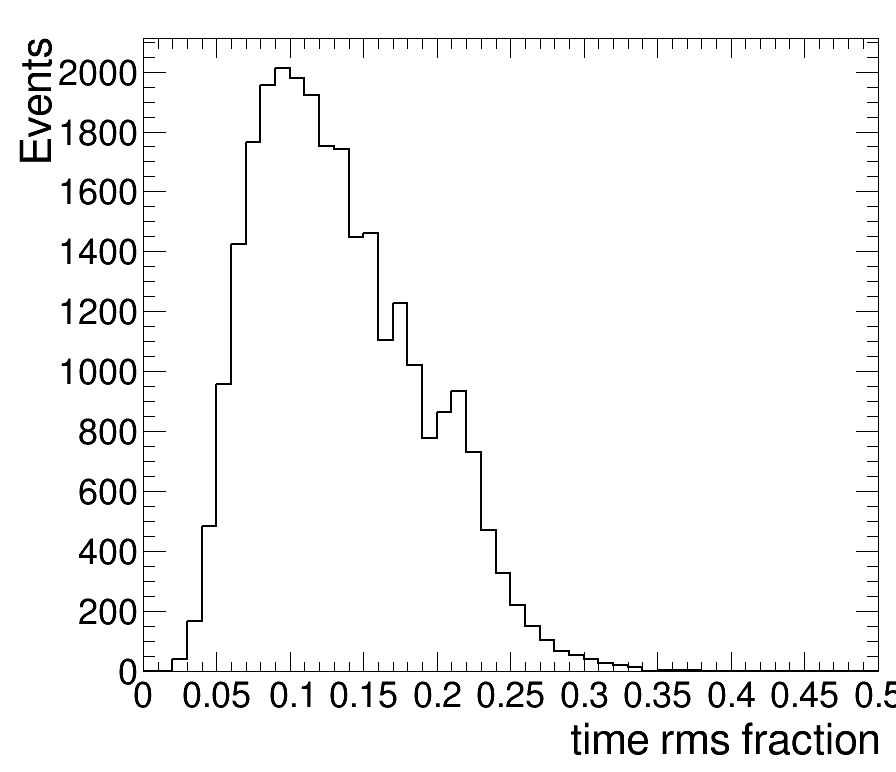

In [385]:
k = 'bbbb_mh125_ctau1'
cond = jetTime[k]>-5
# cond = np.logical_and()
print(np.count_nonzero(cond))
rechitsE = jet_rechits_E[k][cond]
rechitsT = jet_rechits_T[k][cond]
rms = []
for i in range(len(rechitsE)):
#     print(i,len(rechitsE[i]),np.sum(rechitsE[i]),(np.mean(np.array(rechitsE[i])**2))**0.5,jet_frac_energy[k][cond][i])
#     rms.append((np.mean(np.array(rechitsT[i])**2))**0.5/abs(jetTime[k][cond][i]))
#     rms.append((np.mean(np.array(rechitsT[i])**2))**0.5)
    rms.append((np.mean(np.array(rechitsE[i])**2))**0.5/abs(jetEcalEnergy[k][cond][i]))

#     rms.append(abs(np.max(rechitsE[i])-np.min(rechitsE[i]))/np.min(rechitsE[i]))
#     rms.append(np.max(rechitsE[i]))

index = 0
print("jetTime",jetTime[k][cond][index])
print("jetEnergy",jetEcalEnergy[k][cond][index])
print("nRechits",len(rechitsE[index]))
print("jet_frac_energy",jet_frac_energy[k][cond][index])

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.40,0.75,0.95,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)


bins = [50,-5,10]
# h['time'] = create_TH1D(rechitsT[index],axis_title = ['jet time [ns]','Events'], binning=bins)
# h[k] = create_TH1D(rechitsE[index],axis_title = ['jet ECAL Energy [GeV]','Events'], binning=bins)
# h[k] = create_TH2D(np.column_stack((rms,jetTime[k][cond])), axis_title = ['time rms fraction','jet time [ns]','Events'], binning=[50,0,10,50,-10,10])
# h[k] = create_TH1D(rms,axis_title = ['time rms fraction','Events'], binning=bins)
h[k] = create_TH1D(rms,axis_title = ['time rms fraction','Events'], binning=[50,0,0.5])

rms = np.array(rms)
# print(rms)
print(1.0*np.count_nonzero(rms[rms>1.5])/len(rms))
h[k].Draw('colz')
print(rechitsT[index])
print(rechitsE[index])
print(rechit_deltaR[k][cond][index])
# leg.Draw()
c.SetLogz()
c.Draw()



1688
jetTime 1.6058458
jetEnergy 12.07099
nRechits 7
jet_frac_energy 0.9576959484015216
0.0
[2.473742961883545, 0.11693525314331055, 1.4643317461013794, 0.8658785820007324, 6.129714012145996, 2.5039796829223633, 3.4227890968322754]
[1.1570806503295898, 1.6595872640609741, 1.8550059795379639, 4.4597344398498535, 0.5106512904167175, 1.8437222242355347, 0.5852072834968567]
[0.1425426676670716, 0.0875452279926912, 0.10781184918964393, 0.07003191374703198, 0.3056995088768039, 0.08694100801077446, 0.13344006819425375]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


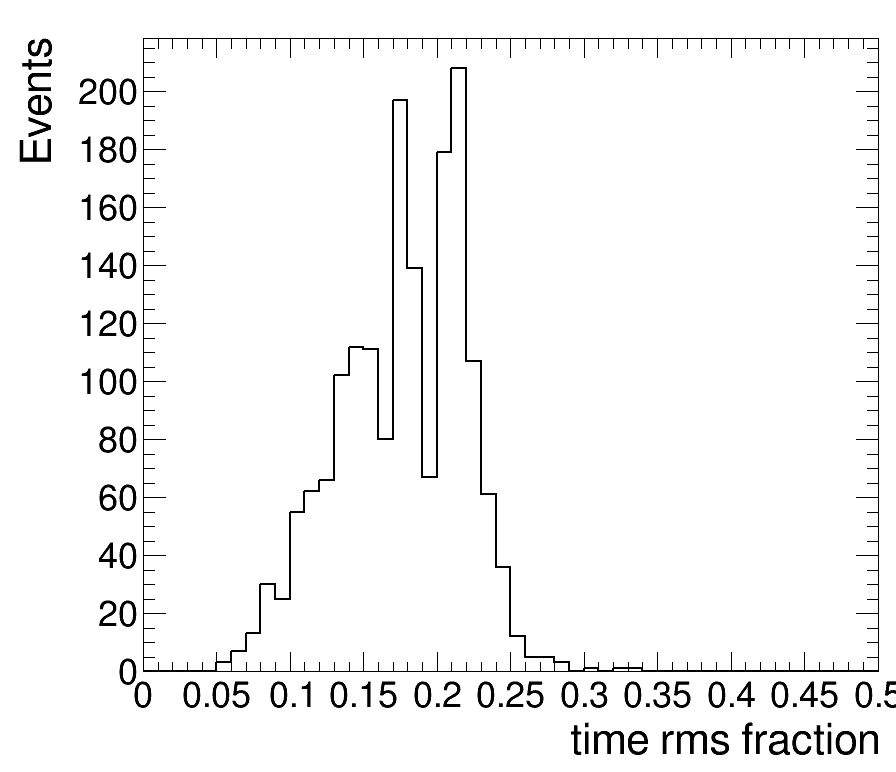

In [383]:
k = 'QCD30'
cond = jetTime[k]>1.5
# cond = np.logical_and()
print(np.count_nonzero(cond))
rechitsE = jet_rechits_E[k][cond]
rechitsT = jet_rechits_T[k][cond]
rms = []
for i in range(len(rechitsE)):
#     print(len(rechitsE[i]),np.sum(rechitsE[i]),(np.mean(np.array(rechitsE[i])**2))**0.5,jet_frac_energy[k][cond][i])
#     rms.append((np.mean(np.array(rechitsT[i])**2))**0.5/abs(jetTime[k][cond][i]))
    rms.append((np.mean(np.array(rechitsE[i])**2))**0.5/abs(jetEcalEnergy[k][cond][i]))

#     rms.append((np.mean(np.array(rechitsT[i])**2))**0.5)
#     rms.append(abs(np.max(rechitsE[i])-np.min(rechitsE[i]))/np.min(rechitsE[i]))

#     rms.append((np.mean(np.array(rechitsE[i])**2))**0.5)
#     rms.append(np.max(rechitsE[i]))

#     rms.append(abs(np.max(rechitsE[i])-np.min(rechitsE[i]))/np.min(rechitsE[i]))
index = 0
print("jetTime",jetTime[k][cond][index])
print("jetEnergy",jetEcalEnergy[k][cond][index])
print("nRechits",len(rechitsE[index]))
print("jet_frac_energy",jet_frac_energy[k][cond][index])

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.40,0.75,0.95,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)


bins = [50,-5,10]
# h['time'] = create_TH1D(rechitsT[index],axis_title = ['jet time [ns]','Events'], binning=bins)
# h[k] = create_TH1D(rechitsE[index],axis_title = ['jet ECAL Energy [GeV]','Events'], binning=bins)
# h[k] = create_TH1D(jetEcalEnergy[k][cond],axis_title = ['jet ECAL Energy [GeV]','Events'], binning=[50,0,50])

# h[k] = create_TH1D(rms,axis_title = ['rechit energy rms [GeV]','Events'], binning=[50,0,5])
# h[k] = create_TH2D(np.column_stack((rms,jetTime[k][cond])), axis_title = ['time rms fraction','jet time [ns]','Events'], binning=[50,0,10,50,-10,10])
h[k] = create_TH1D(rms,axis_title = ['time rms fraction','Events'], binning=bins)
h[k] = create_TH1D(rms,axis_title = ['time rms fraction','Events'], binning=[50,0,0.5])

rms = np.array(rms)
# print(rms)
print(1.0*np.count_nonzero(rms[rms>1.5])/len(rms))
h[k].Draw('colz')
print(rechitsT[index])
print(rechitsE[index])
print(rechit_deltaR[k][cond][index])
# leg.Draw()
c.SetLogz()
c.Draw()
